In [1]:
import pandas as pd
X_train = pd.read_csv("new_split/X_train.csv")
y_train = pd.read_csv("new_split/y_train.csv")

X_val = pd.read_csv("new_split/X_val.csv")
y_val = pd.read_csv("new_split/y_val.csv")

X_test = pd.read_csv("new_split/X_test.csv")
y_test = pd.read_csv("new_split/y_test.csv")

In [2]:
X_train.head()

,YYYY,MM,DD,DOY,2m_temp_mean,2m_dp_temp_mean,10m_wind_u,10m_wind_v,fcst_alb,lai_high_veg,lai_low_veg,swe,surf_net_solar_rad_mean,surf_net_therm_rad_mean,surf_press,total_et,volsw_123,volsw_4,gauge_id,date
0,1981,1,1,1,-0.388068,-0.717942,3.559493,-0.889973,-0.260289,-1.309282,-1.722225,0.135370,-1.082294,0.399797,0.812397,-0.225572,0.387216,-0.525093,357,1981-01-01
1,1981,1,2,2,-0.670595,-0.825833,3.235187,-0.797101,-0.260289,-1.309282,-1.722225,0.135902,-1.054360,0.444297,0.831027,-0.411242,0.387216,-0.525093,357,1981-01-02
2,1981,1,3,3,-0.117313,-0.255054,4.662133,-0.239866,-0.337025,-1.309282,-1.722225,0.092856,-1.096261,-0.594534,0.600979,0.561086,0.387216,-0.525093,357,1981-01-03
3,1981,1,4,4,-0.376296,-0.437771,3.040604,-0.704228,-0.650615,-1.309282,-1.722225,-0.105046,-0.872787,0.798521,0.566626,-0.265150,0.546780,-0.525093,357,1981-01-04
4,1981,1,5,5,-0.882491,-1.037198,2.781159,-2.375932,-0.492468,-1.309282,-1.722225,-0.011466,-1.207998,0.399797,0.656355,-0.668830,0.546780,-0.525093,357,1981-01-05


In [3]:
!nvidia-smi

Tue Dec 16 01:47:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8              2W /   80W |     147MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
cols_to_drop = ["YYYY","MM","DD","DOY"]
X_train.drop(cols_to_drop,axis = 1,inplace=True)
X_val.drop(cols_to_drop,axis = 1,inplace=True)
X_test.drop(cols_to_drop,axis = 1,inplace=True)

In [5]:
import numpy as np

In [6]:
unique_train_gauges = sorted(X_train['gauge_id'].unique())

gauge_mapping = {original_id: new_index for new_index, original_id in enumerate(unique_train_gauges)}


X_train['gauge_index'] = X_train['gauge_id'].map(gauge_mapping)
X_val['gauge_index'] = X_val['gauge_id'].map(gauge_mapping)
X_test['gauge_index'] = X_test['gauge_id'].map(gauge_mapping)

if X_train['gauge_index'].isnull().any():
    raise ValueError("NaNs found in gauge_index. Gauge Consistency check failed.")


N_STATIONS = len(gauge_mapping)
print(f"New N_STATIONS for Embedding: {N_STATIONS}")

New N_STATIONS for Embedding: 100


In [7]:
def create_sequences_for_rnn(X_df, y_series, window_size, gauge_id_col='gauge_index'):
    """
    Transforms 2D tabular data into 3D sequences (LSTM format) 
    and separates the gauge_id for potential Embedding Layer use.
    """
    X_seq, y_seq, gauge_ids_seq = [], [], []
    
   
    df_sorted = X_df.copy()
    df_sorted['target'] = y_series 
    df_sorted.sort_values(by=[gauge_id_col, 'date'], inplace=True)

    
    for gauge_id, group in df_sorted.groupby(gauge_id_col):
        data_and_id = group.drop(columns=['date','gauge_id','gauge_index' ,'target']).values 
        target = group['target'].values
        
        
        for i in range(len(data_and_id) - window_size):
            
            X_seq.append(data_and_id[i:i + window_size])
            
            
            y_seq.append(target[i + window_size])
            
            gauge_ids_seq.append(gauge_id) 

    
    return np.array(X_seq), np.array(y_seq), np.array(gauge_ids_seq)


WINDOW_SIZE = 7 


X_train_seq, y_train_seq, train_gauge_ids = create_sequences_for_rnn(X_train, y_train, WINDOW_SIZE)
X_val_seq, y_val_seq, val_gauge_ids = create_sequences_for_rnn(X_val, y_val, WINDOW_SIZE)
X_test_seq, y_test_seq, test_gauge_ids = create_sequences_for_rnn(X_test, y_test, WINDOW_SIZE)

print("\n--- Final Sequence Shapes ---")
print(f"X_train_seq Shape (N_samples, Window_Size, Features+ID): {X_train_seq.shape}")
print(f"y_train_seq Shape: {y_train_seq.shape}")
print(f"Gauge IDs Shape: {train_gauge_ids.shape}")


--- Final Sequence Shapes ---
X_train_seq Shape (N_samples, Window_Size, Features+ID): (996400, 7, 14)
y_train_seq Shape: (996400,)
Gauge IDs Shape: (996400,)


In [8]:
T = X_train_seq.shape[1]     
F = X_train_seq.shape[2]
N_STATIONS = len(np.unique(train_gauge_ids)) 

print(f"Model Parameters: T={T}, F={F}, N_STATIONS={N_STATIONS}")

Model Parameters: T=7, F=14, N_STATIONS=100


In [9]:
import os

# Set the environment variable to force synchronous CUDA operations
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'



In [10]:
import torch
import torch.nn as nn
import torch.optim as optim



class MultiInputLSTM(nn.Module):
    def __init__(self, T, F, N_STATIONS, lstm_units=100, embedding_size=10, dropout_rate=0.3):
        super(MultiInputLSTM, self).__init__()
        
        self.embedding = nn.Embedding(
            num_embeddings=N_STATIONS + 1,
            embedding_dim=embedding_size
        )
        self.lstm = nn.LSTM(
            input_size=F,
            hidden_size=lstm_units,
            batch_first=True
        )
        
        
        merged_size = lstm_units + embedding_size
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc_out = nn.Linear(in_features=merged_size, out_features=1)
        
    def forward(self, temporal_input, spatial_input):
        
        spatial_embedded = self.embedding(spatial_input.squeeze(1))
        
       
        spatial_flat = spatial_embedded.view(spatial_embedded.size(0), -1)
        
        lstm_out, (h_n, c_n) = self.lstm(temporal_input)
        
       
        lstm_output_last = h_n.squeeze(0) # Shape: (Batch_size, lstm_units)
        
        merged = torch.cat((lstm_output_last, spatial_flat), dim=1)
        
       
        merged = self.dropout(merged)
        
       
        output = self.fc_out(merged)
        
        return output



In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim

# --- 1. Define the Custom Dataset ---
class SequenceDataset(Dataset):
    def __init__(self, X_seq, gauge_ids, y_seq):
        self.X_seq = torch.from_numpy(X_seq).float()
       
        self.gauge_ids = torch.from_numpy(gauge_ids).long().unsqueeze(1) 
       
        self.y_seq = torch.from_numpy(y_seq).float().unsqueeze(1)

    def __len__(self):
        return len(self.y_seq)

    def __getitem__(self, idx):
       
        return self.X_seq[idx], self.gauge_ids[idx], self.y_seq[idx]



In [12]:
BATCH_SIZE = 64  # Good starting batch size


train_dataset = SequenceDataset(X_train_seq, train_gauge_ids, y_train_seq)
val_dataset = SequenceDataset(X_val_seq, val_gauge_ids, y_val_seq)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


T = X_train_seq.shape[1]      
F = X_train_seq.shape[2]      
N_STATIONS = len(np.unique(train_gauge_ids)) 


In [14]:

# Create model instance
model = MultiInputLSTM(T=T, F=F, N_STATIONS=N_STATIONS, lstm_units=100, embedding_size=10)

# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error (MSE) is standard for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [19]:


# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Training on device: {device}")

Training on device: cuda


In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()  
        train_loss = 0.0
        
        
        for i, (X_batch, gauge_batch, y_batch) in enumerate(train_loader):
            
           
            X_batch, gauge_batch, y_batch = X_batch.to(device), gauge_batch.to(device), y_batch.to(device)
            
            
            optimizer.zero_grad()
            
          
            y_pred = model(X_batch, gauge_batch)
            
            
            loss = criterion(y_pred, y_batch)
            
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)

        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad(): 
            for X_batch, gauge_batch, y_batch in val_loader:
                X_batch, gauge_batch, y_batch = X_batch.to(device), gauge_batch.to(device), y_batch.to(device)
                
                y_pred = model(X_batch, gauge_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}')
        
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            
            torch.save(model.state_dict(), 'best_multi_input_lstm.pth')
            print("Model saved (best validation loss).")

    print("Training finished.")



In [ ]:

NUM_EPOCHS = 2
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 1/2 | Train Loss: 25.373690 | Val Loss: 26.649722
Model saved (best validation loss).
Epoch 2/2 | Train Loss: 23.557025 | Val Loss: 26.954982
Training finished.


In [17]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, r2_score

print("--- Starting Final Model Evaluation ---")


loaded_model = MultiInputLSTM(
    T=T, 
    F=F, 
    N_STATIONS=N_STATIONS, 
    lstm_units=100, 
    embedding_size=10
)


try:
    loaded_model.load_state_dict(torch.load('best_multi_input_lstm.pth'))
except FileNotFoundError:
    print("Error: 'best_multi_input_lstm.pth' not found. Check training status.")
    exit()


loaded_model.to(device)
loaded_model.eval() 




BATCH_SIZE = 64
test_dataset = SequenceDataset(X_test_seq, test_gauge_ids, y_test_seq)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)




all_predictions = []
all_true_values = []

with torch.no_grad():
    for X_batch, gauge_batch, y_batch in test_loader:
        
        
        X_batch, gauge_batch = X_batch.to(device), gauge_batch.to(device)
        
        
        y_pred = loaded_model(X_batch, gauge_batch)
        
        
        all_predictions.append(y_pred.cpu().numpy())
        all_true_values.append(y_batch.cpu().numpy())


y_pred_final = np.concatenate(all_predictions).flatten()
y_test_final = np.concatenate(all_true_values).flatten()




test_mse = mean_squared_error(y_test_final, y_pred_final)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_final, y_pred_final)

print("\n--- Final Test Set Performance (Original Units) ---")
print(f"Test RMSE (Root Mean Squared Error): {test_rmse:.4f}")
print(f"Test R-squared (Coefficient of Determination): {test_r2:.4f}")

--- Starting Final Model Evaluation ---

--- Final Test Set Performance (Original Units) ---
Test RMSE (Root Mean Squared Error): 5.1099
Test R-squared (Coefficient of Determination): 0.1664


In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def evaluate_and_plot_flat_input(y_pred_flat, y_test_flat, N_STATIONS, 
                                 model_name="Hybrid LSTM-CNN", 
                                 plot_station_index=0, 
                                 plot_all_flattened=False):
    """
    Calculates aggregate metrics and plots time series using 1D flattened arrays.

    Args:
        y_pred_flat (np.ndarray): 1D array of unscaled predictions (M,).
        y_test_flat (np.ndarray): 1D array of unscaled true targets (M,).
        N_STATIONS (int): The total number of unique stations (N).
        model_name (str): Name for output and titles.
        plot_station_index (int): Index of the station to plot (0 to N-1).
        plot_all_flattened (bool): If True, plots the full flattened series.
    """
    
    # 1. AGGREGATE NUMERICAL METRICS (Calculated on flattened data, which is correct)
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    r2 = r2_score(y_test_flat, y_pred_flat)

    print(f"--- Aggregate Metrics for {model_name} (All Stations & Times) ---")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared Score (R2): {r2:.4f}")
    print("-" * 50)
    
    # Calculate the number of time steps (T)
    if N_STATIONS == 0:
        print("Error: N_STATIONS must be greater than zero.")
        return
        
    M = len(y_test_flat)
    if M % N_STATIONS != 0:
        print(f"Error: Total samples ({M}) is not divisible by N_STATIONS ({N_STATIONS}). Check data integrity.")
        return
        
    N_TIME_STEPS = M // N_STATIONS

    # --- 2. RESHAPE TO 2D (T, N) for Plotting/Slicing ---
    # This assumes the data was concatenated in (Time, Stations) order originally.
    y_test_2D = y_test_flat.reshape(N_TIME_STEPS, N_STATIONS)
    y_pred_2D = y_pred_flat.reshape(N_TIME_STEPS, N_STATIONS)


    if plot_all_flattened:
        # Plotting the flattened sequence (no change needed here)
        plt.figure(figsize=(14, 7))
        plt.plot(y_test_flat, label='True Values (Flattened)', color='blue', linewidth=1)
        plt.plot(y_pred_flat, label='Predicted Values (Flattened)', color='red', linestyle='--', linewidth=1)
        plt.title(f'{model_name} Forecast: True vs. Predicted (All Flattened)')
        plt.suptitle(f'Aggregate RMSE (All Stations): {rmse:.4f}', fontsize=12)
        plt.xlabel('Time Step * Number of Stations (Flattened)')
        plt.ylabel('Target Value (Original Units)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # Residuals for all flattened
        residuals_flat = y_test_flat - y_pred_flat
        plt.figure(figsize=(14, 3))
        plt.plot(residuals_flat, label='Residuals (Error, Flattened)', color='green', linewidth=1)
        plt.axhline(0, color='red', linestyle='-')
        plt.title(f'Residual Plot (Errors Over Time, All Flattened)')
        plt.xlabel('Time Step * Number of Stations (Flattened)')
        plt.ylabel('Residual Value (True - Predicted)')
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        # --- 3. VISUAL ANALYSIS: Plot True vs. Predicted for ONE STATION ---

        # Extract the time series for the selected station from the 2D array
        try:
            y_test_station = y_test_2D[:, plot_station_index]
            y_pred_station = y_pred_2D[:, plot_station_index]
        except IndexError:
            print(f"Error: Station index {plot_station_index} out of bounds (Max index is {N_STATIONS - 1}).")
            return

        # Calculate single-station RMSE for the plot title
        station_rmse = np.sqrt(mean_squared_error(y_test_station, y_pred_station))

        plt.figure(figsize=(14, 7))
        plt.plot(y_test_station, label=f'True Values', color='blue', linewidth=1)
        plt.plot(y_pred_station, label=f'Predicted Values', color='red', linestyle='--', linewidth=1)
        # 
        
        plt.title(f'{model_name} Forecast: True vs. Predicted (Station {plot_station_index})')
        plt.suptitle(f'Aggregate RMSE (All Stations): {rmse:.4f} | Station RMSE: {station_rmse:.4f}', fontsize=12)
        plt.xlabel('Time Step (Test Period)')
        plt.ylabel('Target Value (Original Units)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # --- 4. VISUAL ANALYSIS: Residuals for ONE STATION ---
        residuals_station = y_test_station - y_pred_station

        plt.figure(figsize=(14, 3))
        plt.plot(residuals_station, label='Residuals (Error)', color='green', linewidth=1)
        plt.axhline(0, color='red', linestyle='-')
        plt.title(f'Residual Plot (Errors Over Time) for Station {plot_station_index}')
        plt.xlabel('Time Step (Test Period)')
        plt.ylabel('Residual Value (True - Predicted)')
        plt.legend()
        plt.grid(True)
        plt.show()

# --- Example Usage (Assuming PyTorch output y_pred_final and y_test_final are 1D arrays) ---
# evaluate_and_plot_flat_input(y_pred_final, y_test_final, N_STATIONS=N_STATIONS, plot_station_index=5)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import json
import datetime

# --- 1. SETUP: ASSUME THESE VARIABLES EXIST ---
# y_test: The true target values (e.g., a NumPy array of shape (N, 1) or (N,))
# y_pred: The predicted values from model.predict(X_test_seq) (shape should match y_test)
# ----------------------------------------------
def generate_predictions_sequence(original_y_test_series, look_back = 0, prev_steps = 0):
    """
    Generates naive (t-1) predictions for sequence models.
    For a target y_t, the prediction is y_{t-1}.
    This aligns with how y_test_seq is created from original_y_test_series.
    """
    # y_test_seq was created from original_y_test_series.iloc[look_back:]
    # For y_test_seq[i] (which is original_y_test_series.iloc[look_back + i]),
    # the t-1 prediction is original_y_test_series.iloc[look_back + i - 1].
    # This corresponds to slicing the original series from (look_back - 1) up to (but not including) the last element.
    naive_preds = original_y_test_series.iloc[look_back - prev_steps : len(original_y_test_series) - prev_steps]
    return naive_preds.values

def evaluate(y_pred, y_test, prefix="model", results_dir='results', plot = False):
  # --- 2. CALCULATE NUMERICAL METRICS ---
  print(f"--- Numerical Regression Metrics ({prefix}) ---")

  # Ensure both are flattened to 1D arrays for scikit-learn metrics
  y_test_flat = np.array(y_test).flatten()
  y_pred_flat = np.array(y_pred).flatten()

  # Mean Squared Error (MSE)
  mse = mean_squared_error(y_test_flat, y_pred_flat)

  # Root Mean Squared Error (RMSE) - The most interpretable error metric
  rmse = np.sqrt(mse)

  # Mean Absolute Error (MAE) - Robust to outliers
  mae = mean_absolute_error(y_test_flat, y_pred_flat)

  # R-squared (R2) Score - Goodness of fit (closer to 1.0 is better)
  r2 = r2_score(y_test_flat, y_pred_flat)

  print(f"Mean Squared Error (MSE): {mse:.4f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
  print(f"Mean Absolute Error (MAE): {mae:.4f}")
  print(f"R-squared Score (R2): {r2:.4f}")
  print("-" * 40)

  # Save numerical metrics to JSON
  metrics = {
      "mse": mse,
      "rmse": rmse,
      "mae": mae,
      "r2": r2
  }
  timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
  json_filename = os.path.join(results_dir, f"evaluation_metrics_{prefix}_{timestamp}.json")
  with open(json_filename, 'w') as f:
      json.dump(metrics, f, indent=4)
  print(f"Numerical metrics saved to {json_filename}")


  if plot:
    # --- 3. VISUAL ANALYSIS: Plot True vs. Predicted ---
    # This plot is essential for time series to see if the model captures trends
    plt.figure(figsize=(12, 6))

    # Plot the true values
    plt.plot(y_test_flat, label='True Values', color='blue', linewidth=0.5)

    # Plot the predicted values
    plt.plot(y_pred_flat, label='Predicted Values', color='red', linestyle='--', linewidth=0.5)

    plt.title(f'True vs. Predicted Values (RMSE: {rmse:.4f}) ({prefix})')
    plt.xlabel('Time Step / Sample Index')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    # Save the figure
    plot1_filename = os.path.join(results_dir, f"true_vs_predicted_{prefix}_{timestamp}.png")
    plt.savefig(plot1_filename)
    plt.show() # Display the plot
    print(f"True vs. Predicted plot saved to {plot1_filename}")
    plt.close() # Close the figure to free up memory


    # --- 4. VISUAL ANALYSIS: Plot Residuals ---
    # Residuals = Error = True - Predicted. They should be centered around zero.
    residuals = y_test_flat - y_pred_flat

    plt.figure(figsize=(12, 3))
    plt.plot(residuals, label='Residuals (Error)', color='green', linewidth=0.5)
    plt.axhline(0, color='red', linestyle='-') # Line at zero
    plt.title(f'Residual Plot (Errors Over Time) ({prefix})')
    plt.xlabel('Time Step / Sample Index')
    plt.ylabel('Residual Value (True - Predicted)')
    plt.legend()
    plt.grid(True)
    # Save the figure
    plot2_filename = os.path.join(results_dir, f"residuals_plot_{prefix}_{timestamp}.png")
    plt.savefig(plot2_filename)
    plt.show() # Display the plot
    print(f"Residuals plot saved to {plot2_filename}")
    plt.close() # Close the figure to free up memory

  return metrics


def compare_model_with_baselines(model_name, y_pred_model, y_test_target, y_pred_naive_baseline, y_pred_arima_baseline):
    """
    Evaluates a model's predictions and compares them against naive (t-1) and ARIMA baselines.

    Args:
        model_name (str): Name of the model being evaluated (e.g., 'LSTM', 'XGBoost').
        y_pred_model (np.ndarray): Predictions from the actual model (already inverse-transformed if necessary).
        y_test_target (np.ndarray): True target values corresponding to y_pred_model (already inverse-transformed if necessary).
        y_pred_naive_baseline (np.ndarray): Pre-computed naive (t-1) predictions (already inverse-transformed).
        y_pred_arima_baseline (np.ndarray): Pre-computed ARIMA predictions (already inverse-transformed).
    """
    # Create results directory
    results_dir = "results"
    os.makedirs(results_dir, exist_ok=True) # Ensure directory exists

    print(f"--- Evaluation for {model_name} ---")
    model_metrics = evaluate(y_pred_model, y_test_target, prefix=model_name.replace(' ', '_').lower(), results_dir=results_dir, plot=True)

    print(f"\n--- Comparing {model_name} with Baselines ---")

    print("--- Naive (t-1) Baseline Evaluation ---")
    naive_metrics = evaluate(y_pred_naive_baseline, y_test_target, prefix="naive_baseline", results_dir=results_dir)

    print("--- ARIMA Baseline Evaluation ---")
    arima_metrics = evaluate(y_pred_arima_baseline, y_test_target, prefix="arima_baseline", results_dir=results_dir, plot=True)

    # 2. Create a list of these metric dictionaries
    metrics_list = [model_metrics, arima_metrics, naive_metrics]

    # 4. Create a pandas DataFrame from the list of dictionaries
    metrics_df = pd.DataFrame(metrics_list)

    # 5. Add a new column named 'Model' to the DataFrame
    metrics_df['Model'] = [model_name, 'ARIMA', 'naive (t-1)']

    # Reorder columns to have 'Model' first for better readability
    metrics_df = metrics_df[['Model', 'mse', 'rmse', 'mae', 'r2']]
    metrics_df.transpose()

    print("\n--- Overall Performance Comparison ---")
    print(metrics_df.to_string(index=False))
    print("-" * 50)

    metrics_filename = os.path.join(results_dir, f"{model_name}_evaluation_metrics.csv")
    metrics_df.to_csv(f"metrics_{model_name.replace(' ', '_').lower()}.csv", index=False)
    print(f"{model_name} evaluation metrics saved to {metrics_filename}")


--- Numerical Regression Metrics (model) ---
Mean Squared Error (MSE): 26.1108
Root Mean Squared Error (RMSE): 5.1099
Mean Absolute Error (MAE): 3.1987
R-squared Score (R2): 0.1664
----------------------------------------
Numerical metrics saved to results\evaluation_metrics_model_20251216_010901.json


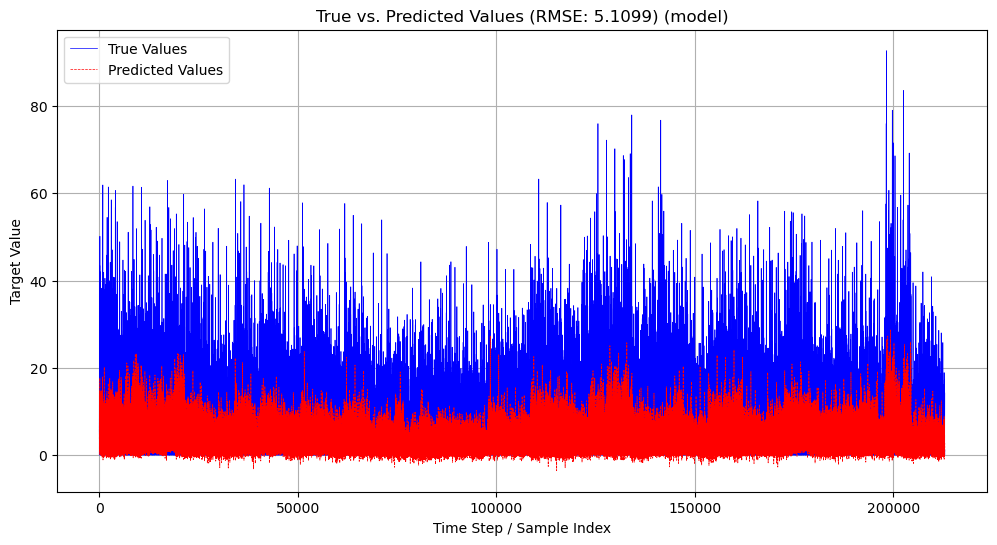

True vs. Predicted plot saved to results\true_vs_predicted_model_20251216_010901.png


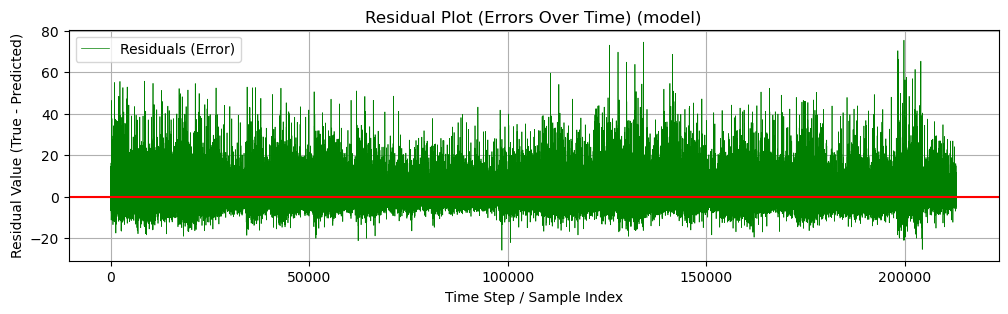

Residuals plot saved to results\residuals_plot_model_20251216_010901.png


{'mse': 26.110788345336914,
 'rmse': np.float64(5.109871656444701),
 'mae': 3.19865083694458,
 'r2': 0.16640061140060425}

In [19]:
evaluate(y_test=y_test_final, y_pred = y_pred_final,plot=True)

--- Aggregate Metrics for Hybrid LSTM-CNN (All Stations & Times) ---
Mean Squared Error (MSE): 25.8321
Root Mean Squared Error (RMSE): 5.0825
Mean Absolute Error (MAE): 3.2184
R-squared Score (R2): 0.1753
--------------------------------------------------


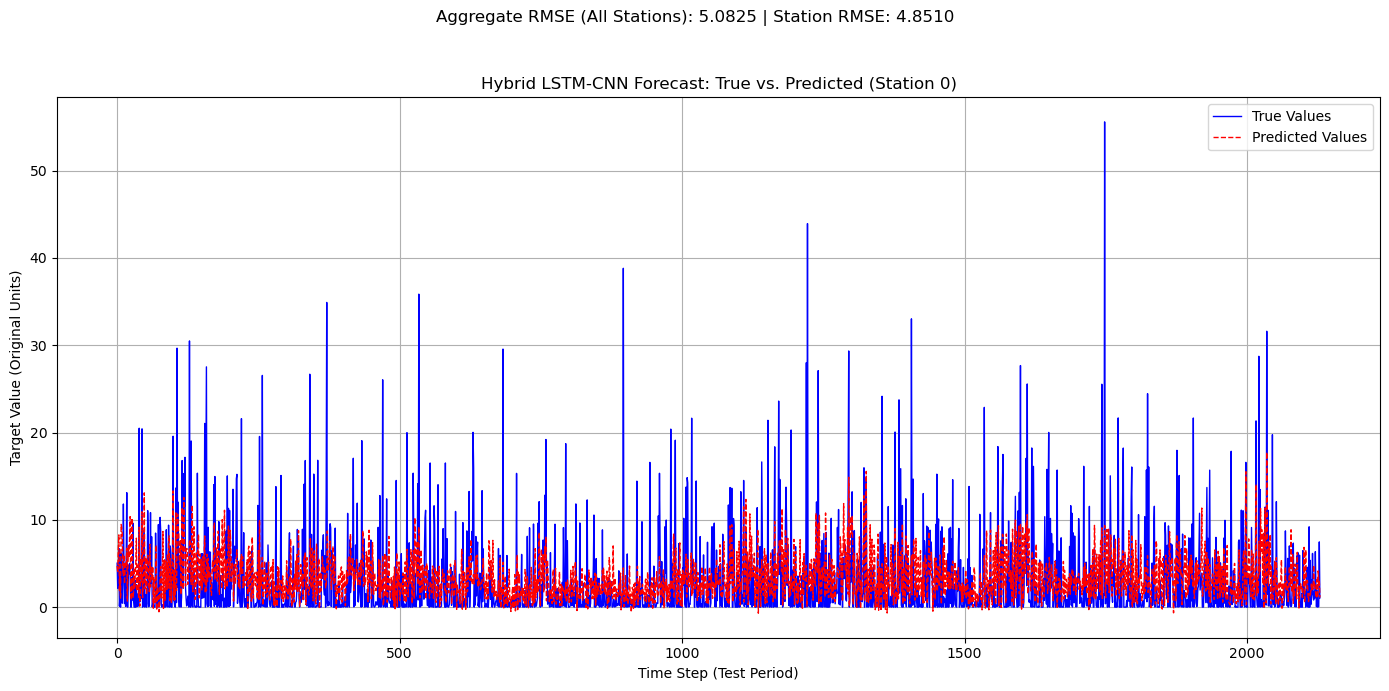

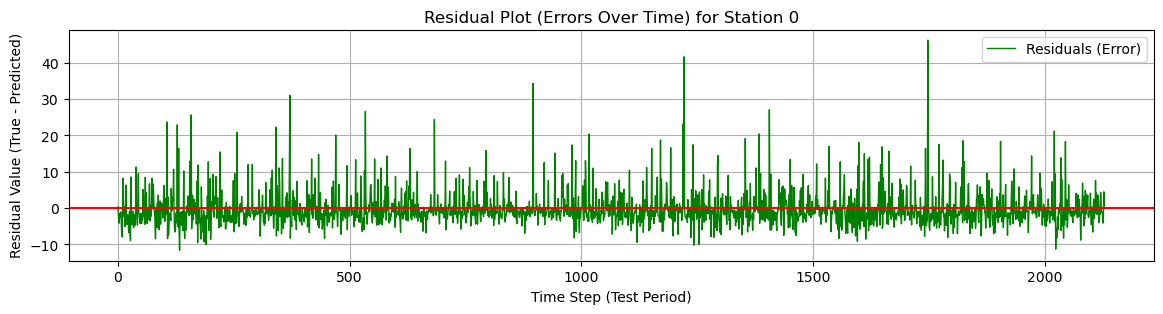

In [23]:
evaluate_and_plot_flat_input(y_pred_final, y_test_final,N_STATIONS=100)

In [21]:
CHECKPOINT_FILE = 'training_checkpoint.pth'

def train_model_optimized(model, model_name,train_loader, val_loader, criterion, optimizer, num_epochs=10, start_epoch=0, best_val_loss=float('inf')):
    

    if start_epoch > 0:
        print(f"Resuming training from Epoch {start_epoch} with best validation loss: {best_val_loss:.6f}")
    

    for epoch in range(start_epoch, num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0
        

        for i, (X_batch, gauge_batch, y_batch) in enumerate(train_loader):
            

            X_batch, gauge_batch, y_batch = X_batch.to(device), gauge_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            

            y_pred = model(X_batch, gauge_batch)
            

            loss = criterion(y_pred, y_batch)
            

            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)


        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, gauge_batch, y_batch in val_loader:
                X_batch, gauge_batch, y_batch = X_batch.to(device), gauge_batch.to(device), y_batch.to(device)
                
                y_pred = model(X_batch, gauge_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}')
        
 
        is_best = epoch_val_loss < best_val_loss
        if is_best:
            best_val_loss = epoch_val_loss
            
 
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, CHECKPOINT_FILE)
        
        if is_best:
 
            torch.save(model.state_dict(), model_name+'\\best_multi_input_lstm.pth')
            print("Model saved (best validation loss).")

    print("Training finished.")



In [ ]:
model = MultiInputLSTM(T=T, F=F, N_STATIONS=N_STATIONS, lstm_units=100, embedding_size=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


start_epoch = 0
best_val_loss = float('inf')

if os.path.exists(CHECKPOINT_FILE):
    print(f"Found checkpoint file: {CHECKPOINT_FILE}. Loading state...")
    checkpoint = torch.load(CHECKPOINT_FILE)
    

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    

    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    
    print(f"Resuming training from epoch {start_epoch}.")
else:
    print("No checkpoint found. Starting training from Epoch 0.")


model.to(device)



NUM_EPOCHS = 10
train_model_optimized(model,"lstm", train_loader, val_loader, criterion, optimizer, 
                      num_epochs=NUM_EPOCHS, 
                      start_epoch=start_epoch, 
                      best_val_loss=best_val_loss)

No checkpoint found. Starting training from Epoch 0.
Epoch 1/10 | Train Loss: 25.398974 | Val Loss: 26.991726
Model saved (best validation loss).
Epoch 2/10 | Train Loss: 23.483647 | Val Loss: 26.873539
Model saved (best validation loss).
Epoch 3/10 | Train Loss: 21.679745 | Val Loss: 27.996462
Epoch 4/10 | Train Loss: 19.987993 | Val Loss: 28.317731
Epoch 5/10 | Train Loss: 18.632287 | Val Loss: 28.486436
Epoch 6/10 | Train Loss: 17.612069 | Val Loss: 29.354877
Epoch 7/10 | Train Loss: 16.872938 | Val Loss: 29.642672
Epoch 8/10 | Train Loss: 16.209786 | Val Loss: 29.619201
Epoch 9/10 | Train Loss: 15.698537 | Val Loss: 30.091873
Epoch 10/10 | Train Loss: 15.278863 | Val Loss: 30.085555
Training finished.


In [17]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, r2_score

print("--- Starting Final Model Evaluation ---")


loaded_model = MultiInputLSTM(
    T=T, 
    F=F, 
    N_STATIONS=N_STATIONS, 
    lstm_units=100, 
    embedding_size=10
)


try:
    checkpoint = torch.load(CHECKPOINT_FILE, map_location=device)
    loaded_model.load_state_dict(torch.load('best_multi_input_lstm.pth'))
except FileNotFoundError:
    print("Error: 'best_multi_input_lstm.pth' not found. Check training status.")
    exit()


loaded_model.to(device)
loaded_model.eval() 




BATCH_SIZE = 64
test_dataset = SequenceDataset(X_test_seq, test_gauge_ids, y_test_seq)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)




all_predictions = []
all_true_values = []

with torch.no_grad():
    for X_batch, gauge_batch, y_batch in test_loader:
        
        
        X_batch, gauge_batch = X_batch.to(device), gauge_batch.to(device)
        
        
        y_pred = loaded_model(X_batch, gauge_batch)
        
        
        all_predictions.append(y_pred.cpu().numpy())
        all_true_values.append(y_batch.cpu().numpy())


y_pred_final = np.concatenate(all_predictions).flatten()
y_test_final = np.concatenate(all_true_values).flatten()




test_mse = mean_squared_error(y_test_final, y_pred_final)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_final, y_pred_final)

print("\n--- Final Test Set Performance (Original Units) ---")
print(f"Test RMSE (Root Mean Squared Error): {test_rmse:.4f}")
print(f"Test R-squared (Coefficient of Determination): {test_r2:.4f}")

--- Starting Final Model Evaluation ---


NameError: name 'CHECKPOINT_FILE' is not defined

--- Aggregate Metrics for Hybrid LSTM-CNN (All Stations & Times) ---
Mean Squared Error (MSE): 26.1108
Root Mean Squared Error (RMSE): 5.1099
Mean Absolute Error (MAE): 3.1987
R-squared Score (R2): 0.1664
--------------------------------------------------


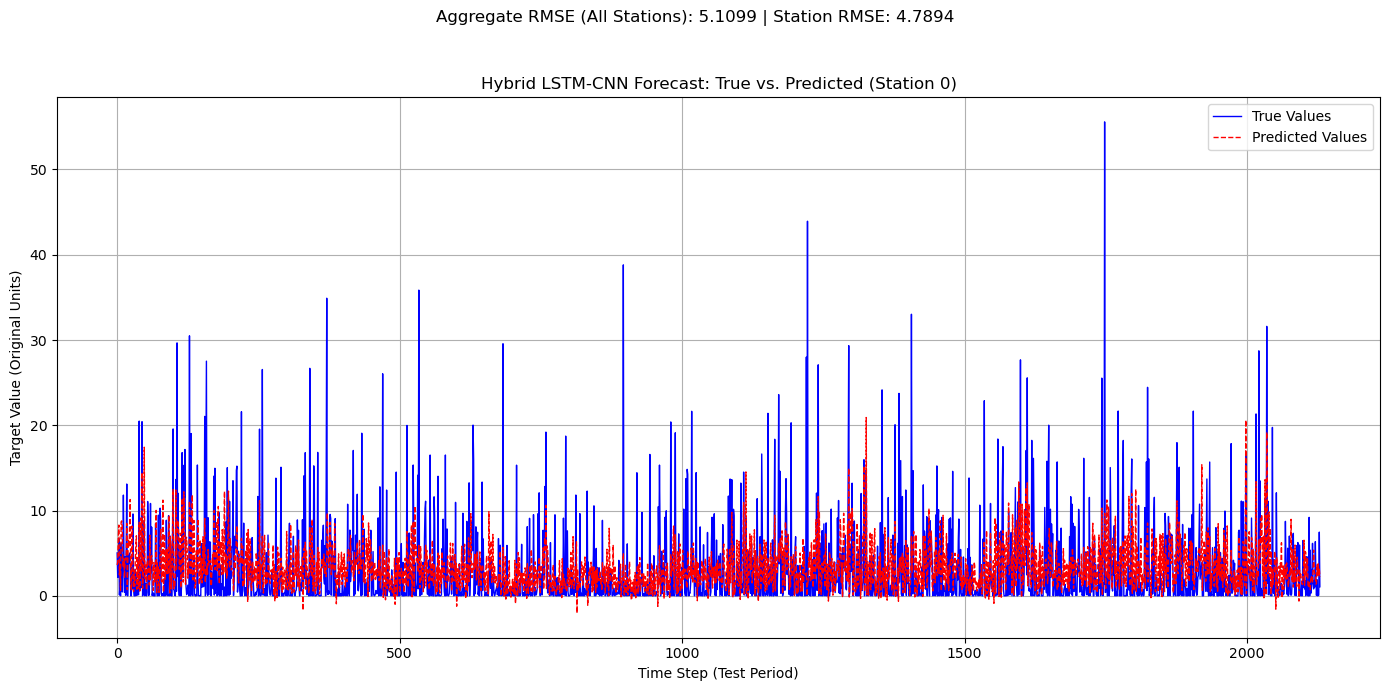

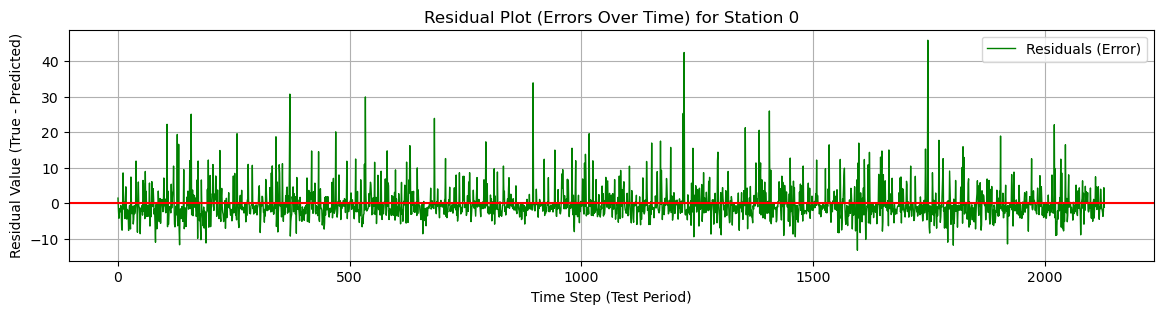

In [31]:
evaluate_and_plot_flat_input(y_pred_final, y_test_final,N_STATIONS=100)

In [23]:
CHECKPOINT_FILE = 'training_checkpoint_2.pth'
model = MultiInputLSTM(T=T, F=F, N_STATIONS=N_STATIONS, lstm_units=30, embedding_size=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


start_epoch = 0
best_val_loss = float('inf')

if os.path.exists(CHECKPOINT_FILE):
    print(f"Found checkpoint file: {CHECKPOINT_FILE}. Loading state...")
    checkpoint = torch.load(CHECKPOINT_FILE)
    

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    

    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    
    print(f"Resuming training from epoch {start_epoch}.")
else:
    print("No checkpoint found. Starting training from Epoch 0.")


model.to(device)



NUM_EPOCHS = 2
train_model_optimized(model,"lstm", train_loader, val_loader, criterion, optimizer, 
                      num_epochs=NUM_EPOCHS, 
                      start_epoch=start_epoch, 
                      best_val_loss=best_val_loss)

No checkpoint found. Starting training from Epoch 0.
Epoch 1/2 | Train Loss: 25.984980 | Val Loss: 26.858890
Model saved (best validation loss).
Epoch 2/2 | Train Loss: 24.875006 | Val Loss: 26.469664
Model saved (best validation loss).
Training finished.


In [27]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, r2_score

# Assuming loaded_model was initialized and loaded with weights previously
model.to(device)
model.eval() 


BATCH_SIZE = 64
# 1. Use the flattened input array X_test_seq_flat
test_dataset = SequenceDataset(X_test_seq, test_gauge_ids, y_test_seq)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


all_predictions = []
all_true_values = []

with torch.no_grad():
    for X_batch, gauge_batch, y_batch in test_loader:
        
        
        # 2. Move both inputs to the device
        X_batch = X_batch.to(device)
        gauge_batch = gauge_batch.to(device)
        
        
        # 3. Model call remains the same (Multi-Input MLP)
        y_pred = loaded_model(X_batch, gauge_batch)
        
        
        all_predictions.append(y_pred.cpu().numpy())
        all_true_values.append(y_batch.cpu().numpy())


y_pred_final = np.concatenate(all_predictions).flatten()
y_test_final = np.concatenate(all_true_values).flatten()

# 4. Metrics calculation remains the same (no inverse transform needed)
test_mse = mean_squared_error(y_test_final, y_pred_final)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_final, y_pred_final)

print("\n--- Final Test Set Performance (Original Units) ---")
print(f"Test RMSE (Root Mean Squared Error): {test_rmse:.4f}")
print(f"Test R-squared (Coefficient of Determination): {test_r2:.4f}")


--- Final Test Set Performance (Original Units) ---
Test RMSE (Root Mean Squared Error): 6.4963
Test R-squared (Coefficient of Determination): -0.3473
